In [1]:
# Feed Forward NN
# Fully connected neural network with two hidden layers
# Author: Karthik D

#Importing Libraries for computation and plotting graph
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler 
import torch as t
import torchvision
import torch.nn as nn
#from torch.utils import data
import torch.utils.data as data_utils
import torch
import hiddenlayer as hl

# Device configuration
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Data prep & Feature Engineering

In [130]:
import json

def is_JSON(js):
    try:
        js = js.replace("\'", "\"")
        jsList = json.loads(js)
    except:
        return False
    return True

def get_fields_from_JSON(js, field, suf):
    suf = "_" + suf
    if js is None:
        return "NA"+suf
    if(is_JSON(js)):
        js = js.replace("\'", "\"")
        jsDict = json.loads(js)[0]
        field = jsDict.get(field, "NA")+suf
        return field
    return "NA"+ suf
        
    
df = pd.read_csv("data.csv")
df = df.drop("id", 1).drop("belongs_to_collection", 1).drop("tagline", 1).drop("overview", 1).drop("original_title", 1).drop("homepage",1).drop("imdb_id", 1).drop("poster_path", 1).drop("title", 1).drop("crew", 1)

# One-hot encoding of features
df = df.join(pd.get_dummies(df["original_language"])).drop("original_language", 1)
df = df.join(pd.get_dummies(df['status'])).drop("status", 1)
df['release_month'] = [row[0] for row in df.release_date.str.split("/")]
df = df.join(pd.get_dummies(df["release_month"])).drop("release_month", 1).drop("release_date", 1)
df = df.join(pd.get_dummies(df.production_countries.apply(get_fields_from_JSON, args=["name", "cntry"]))).drop("production_countries", 1)
df = df.join(pd.get_dummies(df.production_companies.apply(get_fields_from_JSON, args=["name", "cmpny"]))).drop("production_companies", 1)
df = df.join(pd.get_dummies(df.genres.apply(get_fields_from_JSON, args=["name", ""]))).drop("genres", 1)
df = df.join(pd.get_dummies(df.spoken_languages.apply(get_fields_from_JSON, args=["name", "_spk"]))).drop("spoken_languages", 1)
df = df.drop("Keywords", 1).drop("cast", 1)

2


# Train-Test split

In [132]:
def train_test_split(df, perc):
    msk = np.random.rand(len(df)) < perc
    train = df[msk]
    test = df[~msk]
    return train, test

dev_df = df
dev_df = dev_df.dropna()

train, test = train_test_split(dev_df, 0.8)

train_y = train.revenue
train_x = train.drop("revenue", 1)

test_y = test.revenue
test_x = test.drop("revenue", 1)

sc = StandardScaler()
train_x_scaled = sc.fit_transform(train_x)
test_x_scaled = sc.fit_transform(test_x)

print(train_x_scaled.shape); test_x_scaled.shape

(2407, 1232)


/home/karthik/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/karthik/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/karthik/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/karthik/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(591, 1232)

# Convert Raw data to Torch Tensors and Data Loaders

In [133]:
# creating tensor from targets_df 
train_y = torch.Tensor(np.array(train_y))
test_y = torch.Tensor(np.array(test_y))

train_x = torch.Tensor(np.array(train_x_scaled))
test_x = torch.Tensor(np.array(test_x_scaled))

train_dataset = data_utils.TensorDataset(train_x, train_y)
test_dataset = data_utils.TensorDataset(test_x, test_y)

In [140]:
batch_size = 128

train_loader = t.utils.data.DataLoader(dataset=train_dataset,
                                      shuffle=True,
                                      batch_size=batch_size)
test_loader = t.utils.data.DataLoader(dataset=test_dataset,
                                      shuffle=True,
                                      batch_size=batch_size)

# Define Network Hyperparameters

In [162]:
# hyperparameters
input_size = train_x.shape[1]
hidden_size1 = 5000
hidden_size2 = 300
num_epochs = 600
learning_rate = 0.01

# Define Model Architecture

In [165]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout2d(0.4)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout2d(0.3)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)
        
    # Forward
    def forward(self, X):
        out = self.fc1(X)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return(out)

# Train Model

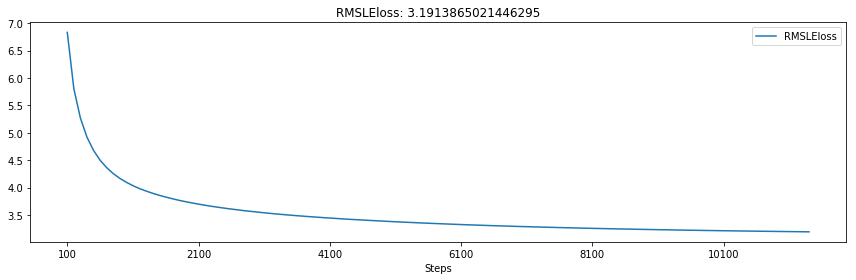

Epoch [600/600], Step [19/19], RMSLE Loss: 2.9737


In [166]:
def rmse(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

def rmsle(y,yp):
    y1 = y
    y1[y1<0] = 0
    return rmse(torch.log1p(y1),torch.log1p(yp)) 

def train_MLP(train_loader):
    
    # A History object to store metrics
    history = hl.History()
    # A Canvas object to draw the metrics
    canvas = hl.Canvas()
    step = sum_loss = 0
    
    # instantiate model
    model = MLP(input_size, hidden_size).to(device)
    # assign loss criterion
    criterion = rmsle
    # Define optimizer
    optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)
    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(train_loader):
            step += 1

            x = x.to(device)
            y = y.to(device)
            
            predict = model(x)
            loss = criterion(predict, y)
            # Backward pass
            optimizer.zero_grad() # set the gradients to zero
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step() # update parameters
            sum_loss += loss.item()
            avg_loss = sum_loss/step
            
            if(step % 100 == 0 ):
                history.log(step, RMSLEloss=avg_loss)
                # Plot the two metrics in one graph
                canvas.draw_plot([history['RMSLEloss']])
            
            print ('Epoch [{}/{}], Step [{}/{}], RMSLE Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    return model
     
mlp = train_MLP(train_loader)

# Test Model

In [167]:
# Test model
def test_MLP(test_loader, model):
    sum_loss = step = 0
    criterion = rmsle
    predict_tensor = torch.Tensor()
    for i, (x, y) in enumerate(test_loader):
            step += 1
            x = x.to(device)
            y = y.to(device)
            predict = model(x)
            loss = criterion(predict, y)
            sum_loss += loss.item()
            avg_loss = sum_loss/step
            predict_tensor = torch.cat((predict_tensor, predict))
            return avg_loss, predict_tensor
        
loss, predict_revenue = test_MLP(test_loader, mlp)

In [168]:
loss

3.1049513816833496

In [169]:
predict_revenue

tensor([[ 4550227.0000],
        [ 2904787.0000],
        [15225994.0000],
        [11693128.0000],
        [ 4247426.5000],
        [10281270.0000],
        [ 3656932.2500],
        [ 2769466.0000],
        [ 5247655.5000],
        [ 3387045.5000],
        [ 3047303.5000],
        [ 5212796.5000],
        [ 2637209.2500],
        [ 3131034.5000],
        [11327660.0000],
        [ 9987859.0000],
        [ 4696838.5000],
        [ 4262682.0000],
        [ 2984881.2500],
        [ 3548048.7500],
        [ 3078378.0000],
        [10676663.0000],
        [ 4240218.5000],
        [ 3167784.2500],
        [ 3645029.5000],
        [11629955.0000],
        [ 2517707.7500],
        [ 6500053.5000],
        [ 6150386.0000],
        [ 4642499.5000],
        [16647557.0000],
        [ 4147846.7500],
        [ 3124373.0000],
        [ 3014160.7500],
        [11672544.0000],
        [16935570.0000],
        [ 8903463.0000],
        [14165683.0000],
        [ 5286514.5000],
        [ 2592782.7500],
